In [21]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
    font-size: 150% !important;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
.code_cell pre {
    font-size: 110% !important;
}
</style>

# Using sympy in genomics risk computation

<b>Lucas Wiman &mdash; Counsyl</b>

2018-04-24


## Sympy

* Symbolic algebra package for python
* Similar idea to Mathematica.
* But it's in _python_, which makes it more useful.
  * `pip install sympy`

Created by Aaron Meurer

## Key features

* Basic algebra
* Basic calculus
* LaTeX math formatting
* Plotting

In [2]:
from sympy import *
import sympy
# Sets up LaTeX output in jupyter notebook:
init_printing()

# Shows plots in jupyter notebook:
%matplotlib inline
from matplotlib import pyplot as plt

x, y, z, n, m, k, i, j = symbols('x, y, z, n, m, k, i, j')
t = Symbol('t')

## "I hate math"

* Think back to math class
* It was boring and repetitive (probably)

* Computers _kill it_ at boring and repetitive

## Example: MacLaurin expansion

Approximate some function with a polynomial:

$$ f(x) = \sum_{n=0}^\infty \frac{f^{(n)}(0)}{n!}x^n $$

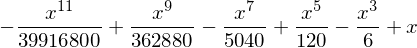

In [3]:
def maclaurin(expression, symbol, n):
    """
    Generate the nth MacLaurin.
    """
    return expression.subs(
        {symbol: 0}) + sum(diff(expression, symbol, i).subs({symbol: 0}) / factorial(i) * (symbol ** i)
        for i in range(1, n+1)
    )

maclaurin(sin(x), x, 11)

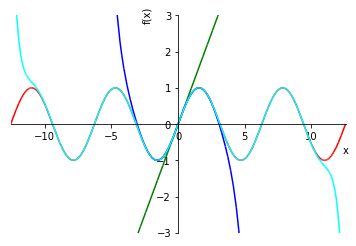

In [4]:
p = plot(sin(x),
         maclaurin(sin(x), x, 1),
         maclaurin(sin(x), x, 7),
         maclaurin(sin(x), x, 27),
         (x, -4 * pi, 4 * pi), ylim=(-3, 3), show=False)
for line, color in zip(p, ['red', 'green', 'blue', 'cyan']):
    line.line_color = color
p.show()

## Genomics Risk Calculation
- Compute risk of heritable disease
- Inherently probabilistic
- Needs to be auditable by nonprogrammers
- Probability is counterintuitive; hard to audit
- `sympy` has auditability tools (plotting, $\LaTeX$).

## Genetics Facts
- Humans are diploid (two copies of each chromosome, except for X/Y)
- Gametes (egg/sperm cells) are haploid (one copy)
- Many diseases are _recessive_; both parents must pass a mutation to cause disease.

## Scenario
- Both patients test negative for cystic fibrosis.
- Incidence 1/3,900.
- 99% detection rate
$$ \textrm{detection rate} = P(\textrm{mutation detected}\ |\ \textrm{mutation present}) $$

## Goal: use Bayes' law to compute reproductive risk

## Bae's theorem 
$$
P(\textrm{chill}\ |\ \textrm{netflix}) = \frac{P(\textrm{netflix}\ |\ \textrm{chill})P(\textrm{chill})}{P(\textrm{netflix})}
$$
(h/t @alittlestats https://twitter.com/alittlestats/status/664923862853922820)

## Bayes' theorem 
$$
P(A\ |\ B) = \frac{P(B\ |\ A)P(A)}{P(B)}
$$
(h/t Rev. Thomas Bayes https://en.wikipedia.org/wiki/Bayes%27_theorem)

In [5]:
import itertools, collections, operator
from functools import reduce
from typing import *
from numbers import *

Probability = Union[Number, sympy.Expr]

In [6]:
class ProbabilityDistribution(Dict[Any, Probability]):
    def bayes_update(self, likelihood: dict):
        updated = ProbabilityDistribution({
            event: probability * likelihood[event]
            for event, probability in self.items()
        })
        denominator = sympy.simplify(sum(updated.values()))
        for event in updated:
            updated[event] = sympy.simplify(updated[event] / denominator)
        return updated
    def cartesian_product(self, *other_distributions):
        event_to_probability = collections.defaultdict(float)
        distributions = [self, *other_distributions]
        for events in itertools.product(*distributions):
            probabilities = [distribution[event] for distribution, event in zip(distributions, events)]
            event_to_probability[events] += reduce(operator.mul, probabilities, 1)
        return ProbabilityDistribution(event_to_probability)
    __mul__ = cartesian_product

```python
class ProbabilityDistribution(Dict[Any, Probability]):
    def bayes_update(self, likelihood: dict):
        updated = ProbabilityDistribution({
            event: probability * likelihood[event]
            for event, probability in self.items()
        })
        denominator = sympy.simplify(sum(updated.values()))
        for event in updated:
            updated[event] = sympy.simplify(updated[event] / denominator)
        return updated
```

- Core class; a dictionary with two extra operations.
- Generalized version of Baye's law.
- likelihood is a dict whose values are conditional probs.
- _not itself a distribution_ (probabilities don't sum to 1)

```python
class ProbabilityDistribution(Dict[Any, Probability]):
    def cartesian_product(self, *other_distributions):
        event_to_probability = collections.defaultdict(float)
        distributions = [self, *other_distributions]
        for events in itertools.product(*distributions):
            probabilities = [distribution[event] for distribution, event in zip(distributions, events)]
            event_to_probability[events] += reduce(operator.mul, probabilities, 1)
        return ProbabilityDistribution(event_to_probability)
    __mul__ = cartesian_product
```

- Takes the product of two probability distributions.
- Events are tuples.
- Override the dunder-mul operator for brevity
- Sympy has probability distributions, but they're more abstract than this.

In [7]:
p = symbols('p')
d = ProbabilityDistribution({'heads': p, 'tails': 1 - p})
ten_tosses = d.cartesian_product(*([d] * 9))

def at_least_seven_heads(tosses: tuple):
    return len([e for e in tosses if e == 'heads']) >= 7

sum(probability for tosses, probability in ten_tosses.items()
    if at_least_seven_heads(tosses))

## Sexual Reproduction 🐦🐝
- _Meiosis_ forms haploid sperm/egg cells.
- Probability of a particular mutation being transmitted is 50%

- For illustration, I've included two species which reproduce sexually.

## Sexual Reproduction 🐦🐝 (cont'd)
- _Fertilization_ of egg/sperm generates a diploid cell.
- 9 months later 👶

## Punnett Square
<table>
    <tr>
        <td></td>
        <th>A</th>
        <th>a</th>
    </tr>
    <tr>
        <th>A</th>
        <td style="color: green;">AA</td>
        <td style="color: blue; font-weight: bold;">Aa</td>
    </tr>
    <tr>
        <th>a</th>
        <td style="color: blue; font-weight: bold;">aA</td>
        <td><b style="color: red">aa</b></td>
    </tr>
</table>

Let $q$ denote the freqency of A, $p=1-q$ denote the frequency of a in the population.

- `a` is deleterious (recessive)
- `A` is benign (dominant)
- `aa` is disease causing

In [8]:
def meiosis(diploid_dist: ProbabilityDistribution):
    gamete = defaultdict(lambda: 0)
    for (geno1, geno2), prob in diploid_dist.items():
        gamete[geno1] = gamete[geno1] + prob / 2
        gamete[geno2] = gamete[geno2] + prob / 2
    return ProbabilityDistribution(gamete)

In [9]:
def fertilize(egg: ProbabilityDistribution,
              sperm: ProbabilityDistribution):
    return egg * sperm

In [10]:
mutant, wildtype = 'mutant (a)', 'wildtype (A)'
haploid_prior = ProbabilityDistribution({
    mutant: p,
    wildtype: 1 - p,
})
diploid_prior = haploid_prior * haploid_prior
diploid_prior

{('mutant (a)', 'mutant (a)'): p**2,
 ('mutant (a)', 'wildtype (A)'): p*(-p + 1),
 ('wildtype (A)', 'mutant (a)'): p*(-p + 1),
 ('wildtype (A)', 'wildtype (A)'): (-p + 1)**2}

Tested negative; but mutations may have gone undetected.

In [16]:
detection_rate = sympy.Symbol('d')
likelihood = {
    # two mutations, both undetected
    (mutant, mutant): (1 - detection_rate) ** 2,
    
    # one mutation, undetected
    (mutant, wildtype): 1 - detection_rate,
    (wildtype, mutant): 1 - detection_rate,
    
    # no mutations
    (wildtype, wildtype): 1,
}

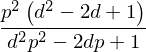

In [18]:
mother_posterior = father_posterior = \
    diploid_prior.bayes_update(likelihood)
egg_posterior = meiosis(mother_posterior)
sperm_posterior = meiosis(father_posterior)
child_posterior = fertilize(egg_posterior, sperm_posterior)
AFFECTED = (mutant, mutant)
reproductive_risk = sympy.simplify(child_posterior[AFFECTED])
reproductive_risk

## Odds for various mutation frequencies

```python
plt = plot(
    1 / reproductive_risk.subs({detection_rate: 0.99}),
    1 / (p ** 2),  # prior
    (p, 0, 1),
    yscale='log',
    xlabel='Mutation Frequency',
    ylabel='',
    title='Risk (1 in ...)',
    show=False)
plt[1].line_color = 'red'
plt.show()
```

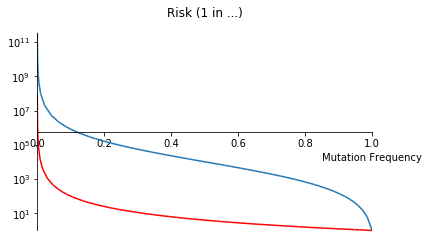

In [19]:
plt = plot(
    1 / reproductive_risk.subs({detection_rate: 0.99}),
    1 / (p ** 2),  # prior
    (p, 0, 1),
    yscale='log',
    xlabel='Mutation Frequency',
    ylabel='',
    title='Risk (1 in ...)',
    show=False)
plt[1].line_color = 'red'
plt.show()

## Odds for various detection rates

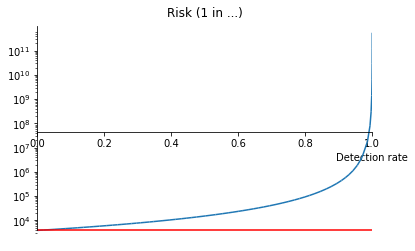

In [20]:
mutation_frequency = 1 / 62
plt = plot(
    1 / reproductive_risk.subs({p: mutation_frequency}),
    1/(mutation_frequency ** 2),  # prior
    (detection_rate, 0, 1), yscale='log',
    xlabel='Detection rate', ylabel='',
    title='Risk (1 in ...)', show=False)
plt[1].line_color = 'red'
plt.show()

## Summary
- `sympy` handles tedious algebra.
- Useful for graphing, debugging, auditability.
- Hopefully you learned a little genetics too!